# Machine Learning Exercise 11

# Transfer Learning - ARGOS 



##Import 

Import libraries and print some versions.

To use GPU, set `Edit / Notebook settings / Hardware accelerator` to **GPU**.

In [ ]:
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf
import keras

print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Using TensorFlow backend.


Tensorflow version 1.15.0
Found GPU at: /device:GPU:0


## Load data

Get data from  https://drive.google.com/drive/folders/0Bxxqx_AAp2u2Zkp4cGxoNVEzb3M

Place data in a Google folder and set the datadir variable below with the path of this folder.

Get Google Drive access

Load training data

4774 images from 20 classes



In [ ]:
import os
from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator
drive.mount('/content/drive')

datadir = '/content/drive/My Drive/ARGOS_public'
trainingset = datadir+'/train/'
testset = datadir + '/test/'

batch_size = 64
input_shape = ()
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False)

train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 4773 images belonging to 20 classes.
Found 1665 images belonging to 20 classes.
Image input (118, 224, 3)
Classes: ['Acqua', 'Alilaguna', 'Ambulanza', 'Barchino', 'Cacciapesca', 'Caorlina', 'Gondola', 'Lancia', 'Motobarca', 'Motopontonerettangolare', 'MotoscafoACTV', 'Mototopo', 'Patanella', 'Polizia', 'Raccoltarifiuti', 'Sandoloaremi', 'Sanpierota', 'Topa', 'VaporettoACTV', 'VigilidelFuoco']
Loaded 4773 training samples from 20 classes.
Loaded 1665 test samples from 20 classes.


## Show random image



Patanella


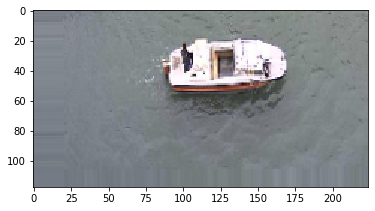

Topa


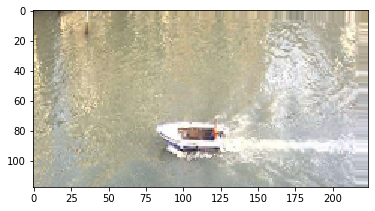

VaporettoACTV


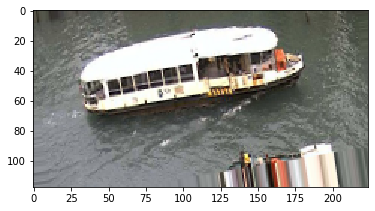

In [ ]:
import matplotlib.pyplot as plt

n = 3
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()


##RandNet model


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,\
                         UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers


def RandNet(input_shape, num_classes):
    
    model = Sequential(name="RandNet")
    
    model.add(Conv2D(32, kernel_size=(2, 2), strides=(1, 1), activation='relu', input_shape=input_shape, padding="valid"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
    model.add(BatchNormalization())

    model.add(Conv2D(64, kernel_size=(2, 2), strides=(1, 1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
    model.add(BatchNormalization())

    model.add(Conv2D(165, kernel_size=(2, 2), strides=(1, 1), activation='relu', padding='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(num_classes, activation='softmax'))


    optimizer = 'adam' #alternative 'SGD'
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    
    return model
 
# create the model
model = RandNet(input_shape, num_classes)
model.summary()

## Train

In [ ]:
from keras import callbacks

stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=4)

steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

try:
    history = model.fit_generator(train_generator, epochs=100, verbose=1, callbacks=[stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass


##Transfer Learning

In [ ]:
from keras import applications
from keras.models import Model, Input


def load_backbone_net(input_shape):
    
    # define input tensor
    input0 = Input(shape=input_shape)

    # load a pretrained model on imagenet without the final dense layer
    feature_extractor = applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=input0)
    
    
    feature_extractor = feature_extractor.output
    feature_extractor = Model(input=input0, output=feature_extractor)
    optimizer = 'adam' #alternative 'SGD'

    feature_extractor.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return feature_extractor


def transferNet(feature_extractor, num_classes, output_layer_name, trainable_layers):
    
    # get the original input layer tensor
    input_t = feature_extractor.get_layer(index=0).input

    # set the feture extractor layers as non-trainable
    for idx,layer in enumerate(feature_extractor.layers):
      if layer.name in trainable_layers:
        layer.trainable = True
      else:
        layer.trainable = False

    # get the output tensor from a layer of the feature extractor
    output_extractor = feature_extractor.get_layer(name = output_layer_name).output
    
    #output_extractor = MaxPooling2D(pool_size=(4,4))(output_extractor)

    # flat the output of a Conv layer
    flatten = Flatten()(output_extractor) 
    flatten_norm = BatchNormalization()(flatten)

    # add a Dense layer
    dense = Dropout(0.4)(flatten_norm)
    dense = Dense(200, activation='relu')(dense)
    dense = BatchNormalization()(dense)
    
    # add a Dense layer
    dense = Dropout(0.4)(dense)
    dense = Dense(100, activation='relu')(dense)
    dense = BatchNormalization()(dense)

    # add the final output layer
    dense = BatchNormalization()(dense)
    dense = Dense(num_classes, activation='softmax')(dense)
    

    model = Model(input=input_t, output=dense, name="transferNet")
    
    optimizer = 'adam' #alternative 'SGD'
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return model

# load the pre-trained model
feature_extractor = load_backbone_net(input_shape)
feature_extractor.summary()


# choose the layer from which you can get the features (block5_pool the end, glob_pooling to get the pooled version of the output)
name_output_extractor = "block5_pool"
trainable_layers = ["block5_conv3"]

# build the transfer model
transfer_model = transferNet(feature_extractor, num_classes, name_output_extractor, trainable_layers)
transfer_model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("bl...)`


Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 118, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 118, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 118, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 59, 112, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 59, 112, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 59, 112, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 29, 56, 128)       0  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="transferNet", inputs=Tensor("in..., outputs=Tensor("de...)`


In [ ]:
# fit the transferNet on the training data
stopping = callbacks.EarlyStopping(monitor='val_acc', patience=3)

steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = test_generator.n//test_generator.batch_size+1

try:
    history_transfer = transfer_model.fit_generator(train_generator, epochs=100, verbose=1, callbacks=[stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass


Epoch 1/100
73/74 [============================>.] - ETA: 16s - loss: 1.3896 - acc: 0.6279

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 11 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 12 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 13 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 14 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 15 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 16 could not be retrieved. It could b

Decrease data Augmentation to increase difficulty

In [ ]:
# reset the data generator

train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=1,\
    width_shift_range=0,\
    height_shift_range=0,\
    horizontal_flip=True,\
    vertical_flip=False)


# set the shuffle flag to False
train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Train and test a simple classifier (Shallow NN)

In [ ]:
# define a shallow neural net
def shallowNet(feature_extractor, num_classes):
    
    # get the original input layer tensor
    input_t = feature_extractor.get_layer(index=0).input

    # set the feture extractor layers as non-trainable
    for idx,layer in enumerate(feature_extractor.layers):
        layer.trainable = False

    # get the last tensor from the feature extractor
    output_extractor = feature_extractor.output
    
    flatten = Flatten()(output_extractor) 
    flatten_norm = BatchNormalization()(flatten)
    
    # add the final output layer
    dense = Dense(num_classes, activation='softmax')(flatten_norm)
    

    shallow_model = Model(input=input_t, output=dense, name="shallowNet")
    
    
    optimizer = 'adam' #alternative 'SGD'
    shallow_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    
    return shallow_model


shallow_model = shallowNet(feature_extractor, num_classes)
shallow_model.summary()

In [ ]:
# train the shallow model
try:
    history_shallow= shallow_model.fit_generator(train_generator, epochs=5, verbose=1, callbacks=[stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

## Print scores


Confusion matrix analysis

In [ ]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# predictions from transferNet
preds = transfer_model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))
  

Found 1686 images belonging to 20 classes.
53/53 [==============================] - 10s 194ms/step
Test set with 1686 images
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
Barchino         ->  Lancia            	32 	1.90 % 
Mototopo         ->  Motobarca         	31 	1.84 % 
Acqua            ->  Lancia            	30 	1.78 % 
Patanella        ->  Lancia            	25 	1.48 % 
Topa             ->  Lancia            	16 	0.95 % 
Motobarca        ->  Mototopo          	14 	0.83 % 
Barchino         ->  Patanella         	11 	0.65 % 
Lancia           ->  Alilaguna         	10 	0.59 % 
Acqua            ->  Mototopo          	10 	0.59 % 
Motobarca        ->  Lancia            	9 	0.53 % 
Mototopo         ->  Lancia            	8 	0.47 % 
Acqua            ->  Patanella         	7 	0.42 % 
Lancia           ->  Acqua             	6 	0.36 % 
Mototopo         ->  Alilaguna         	6 	0.36 % 
Polizia          ->  Lancia   

##Plot results

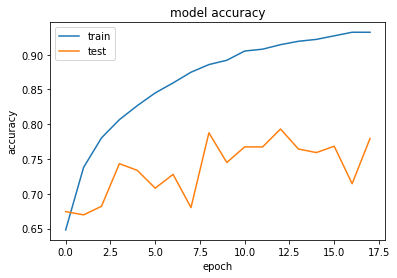

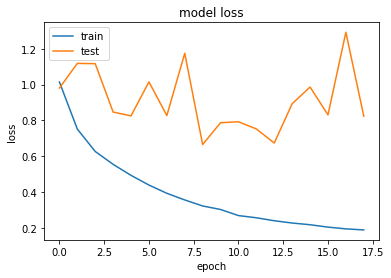

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history,name):

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    
name="RandNet"
plot_history(history, name)
name="transferNet"
plot_history(history_transfer, name)
name="shallowNet"
plot_history(history_shallow, name)